## Importing libraries and dependencies

In [57]:
!gsutil -m cp gs://dtire-special-storage/archive.zip .
!ls -l

Copying gs://dtire-special-storage/archive.zip...
- [1/1 files][707.6 MiB/707.6 MiB] 100% Done  10.1 MiB/s ETA 00:00:00           
Operation completed over 1 objects/707.6 MiB.                                    
total 724616
-rw-r--r-- 1 root root 741994332 Jun  8 14:10  archive.zip
drwxr-xr-x 1 root root      4096 Jun  1 13:50  sample_data
drwxr-xr-x 4 root root      4096 Jun  8 13:28 'Tire Textures'


In [73]:
!unzip -q archive.zip

replace Tire Textures/testing_data/cracked/Cracked-1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [74]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import glob
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Conv2D,Flatten,Dropout,Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model

from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix, classification_report

# HyperParameter


In [75]:
train_path='./Tire Textures/training_data'
test_path='./Tire Textures/testing_data'
EPOCHS=15
BATCH_SIZE=8
RANDOM_SEED=16

# Data visualization

In [76]:
labels=os.listdir(train_path)
labels

['normal', 'cracked']

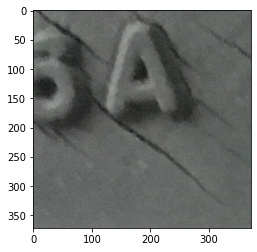

In [77]:
train_cracked=train_path+"/cracked/"
train_normal=train_path+"/normal/"

len(os.listdir(train_cracked))
random_num=np.random.randint(0,len(os.listdir(train_cracked)))
pic_path=os.listdir(train_cracked)[random_num]

img_path=train_cracked + pic_path
plt.imshow(plt.imread(img_path))

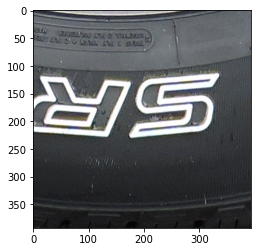

In [78]:
train_normal=train_path+"/normal/"
len(os.listdir(train_normal))
random_num=np.random.randint(0,len(os.listdir(train_normal)))
pic_path=os.listdir(train_normal)[random_num]

img_path=train_normal + pic_path
plt.imshow(plt.imread(img_path))

# Preparing our dataset

In [79]:
def process(data):
    path=Path(data) #get the path
    filepaths=list(path.glob(r"*/*.jpg")) # get all the subpath
    labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths)) #get the label for each subpath
    df1=pd.Series(filepaths,name='filepaths').astype(str)
    df2=pd.Series(labels,name='labels')
    df=pd.concat([df1,df2],axis=1) # concat the series of filepaths and label to be one dataframe
    return df

In [111]:
train=process(train_path)
test=process(test_path)

# merge the dataset
df_full = pd.concat([train, test], axis=0)
df_full = df_full.sample(frac=1, random_state=RANDOM_SEED)

# split the full dataset by 0.8/0.2 to train and test
sliceIdx= int(0.7*len(df_full))
df_train = df_full.iloc[:sliceIdx,:]
df_test_full = df_full.iloc[sliceIdx:,:]

# split the test dataset to val and test
sliceIdx= int(0.5*len(df_test_full))
df_val = df_test_full.iloc[:sliceIdx,:]
df_test = df_test_full.iloc[sliceIdx:,:]




print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

print(df_train['labels'].value_counts()['normal'])

(719, 2)
(154, 2)
(155, 2)
333


In [112]:
train_generator = ImageDataGenerator( preprocessing_function=preprocess_input, rotation_range = 10, zoom_range = 0.4, width_shift_range=0.1, horizontal_flip=True, )
val_generator = ImageDataGenerator( preprocessing_function=preprocess_input)
test_generator = ImageDataGenerator( preprocessing_function=preprocess_input)

In [113]:
train_image=train_generator.flow_from_dataframe(dataframe=df_train,
                                                x_col='filepaths',
                                                y_col='labels',
                                                class_mode='binary',
                                                target_size=(150,150),
                                                batch_size=BATCH_SIZE,                                               
                                                random_seed=RANDOM_SEED)

val_image=val_generator.flow_from_dataframe(dataframe=df_val,
                                                x_col='filepaths',
                                                y_col='labels',
                                                class_mode='binary',
                                                target_size=(150,150),
                                                batch_size=BATCH_SIZE,  
                                                                                             
                                                random_seed=RANDOM_SEED)

test_image = test_generator.flow_from_dataframe(
                                                dataframe=df_test,
                                                x_col='filepaths',
                                                y_col='labels',
                                                class_mode='binary',
                                                shuffle=False,
                                                target_size=(150,150),
                                                batch_size=BATCH_SIZE,
)

Found 719 validated image filenames belonging to 2 classes.
Found 154 validated image filenames belonging to 2 classes.
Found 155 validated image filenames belonging to 2 classes.


# Model building

In [114]:
pretrained_model = ResNet50(
    input_shape=(150,150, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
pretrained_model.trainable = False #We don't want to train again the resnet



In [115]:
inputs = pretrained_model.input


x = Dense(64, activation='relu')(pretrained_model.output)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)#adding some custom output layer base on need.
#output layer has 1 unit neuron for classify
outputs = Dense(1, activation='sigmoid')(x)


model = Model(inputs=inputs, outputs=outputs)

In [116]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model Architecture

In [117]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

# Training

In [118]:
mo_fit=model.fit(train_image,
                 epochs=EPOCHS,
                 validation_data=val_image,
                 verbose = 1)

Epoch 1/15
90/90 [==============================] - 42s 432ms/step - loss: 0.6721 - accuracy: 0.7218 - val_loss: 0.4200 - val_accuracy: 0.7792
Epoch 2/15
90/90 [==============================] - 38s 420ms/step - loss: 0.3678 - accuracy: 0.8470 - val_loss: 0.3593 - val_accuracy: 0.8636
Epoch 3/15
90/90 [==============================] - 36s 407ms/step - loss: 0.3742 - accuracy: 0.8414 - val_loss: 0.3081 - val_accuracy: 0.8766
Epoch 4/15
90/90 [==============================] - 37s 405ms/step - loss: 0.3329 - accuracy: 0.8414 - val_loss: 0.3438 - val_accuracy: 0.8701
Epoch 5/15
90/90 [==============================] - 37s 411ms/step - loss: 0.2752 - accuracy: 0.8846 - val_loss: 0.3414 - val_accuracy: 0.8506
Epoch 6/15
90/90 [==============================] - 37s 408ms/step - loss: 0.2352 - accuracy: 0.8999 - val_loss: 0.3365 - val_accuracy: 0.8506
Epoch 7/15
90/90 [==============================] - 36s 403ms/step - loss: 0.2200 - accuracy: 0.9082 - val_loss: 0.4715 - val_accuracy: 0.8766

# Performance plots

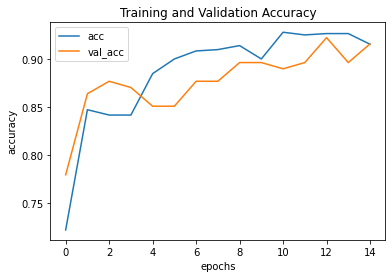

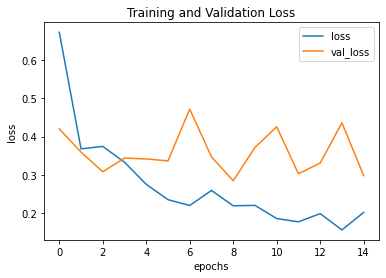

In [119]:
acc = mo_fit.history['accuracy']
val_acc = mo_fit.history['val_accuracy']
loss = mo_fit.history['loss']
val_loss = mo_fit.history['val_loss']
epochs = range(len(acc))

plt.plot(acc)
plt.plot(val_acc)
plt.title("Training and Validation Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(['acc', 'val_acc'])
plt.show()
print('')
plt.plot(loss)
plt.plot(val_loss)
plt.title("Training and Validation Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['loss', 'val_loss'])

# Evaluation on test set

In [120]:
model.evaluate(test_image)

20/20 [==============================] - 6s 291ms/step - loss: 0.1786 - accuracy: 0.9161


[0.17862387001514435, 0.9161290526390076]

In [121]:
test_pred = model.predict(test_image)
THRESHOLD = 0.5
test_pred_class = (test_pred >= THRESHOLD).reshape(-1,)

test_image_class = test_image.classes
print('F1 Score : ', f1_score(test_image_class, test_pred_class))

pd.DataFrame(
    confusion_matrix(test_image_class, test_pred_class),
    index = [["actual", "actual"],["normal", "cracked"]],
    columns = [["predicted", "predicted"], ["normal","cracked"]]
)


F1 Score :  0.9239766081871345


predicted        
                  normal cracked
actual normal         63      10
       cracked         3      79

# Save the Model

In [122]:
model.save("saved_models/v3/")

INFO:tensorflow:Assets written to: saved_models/v3/assets


In [124]:
!zip -r model_v2.zip saved_models/v3

  adding: saved_models/v3/ (stored 0%)
  adding: saved_models/v3/saved_model.pb (deflated 92%)
  adding: saved_models/v3/keras_metadata.pb (deflated 95%)
  adding: saved_models/v3/assets/ (stored 0%)
  adding: saved_models/v3/variables/ (stored 0%)
  adding: saved_models/v3/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: saved_models/v3/variables/variables.index (deflated 80%)


Test with your arbitrary image

In [ ]:

image_path = "test_cracked5.jpg"

img = tf.keras.utils.load_img(image_path, target_size=(150, 150), )
img_arr = tf.keras.utils.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)
img_arr = preprocess_input(img_arr)
np.set_printoptions(suppress=True)

model.predict(img_arr)

array([[0.00001007]], dtype=float32)